# ZNE with indirect-control VQE
---

This experiment is:

- Qubit: 7, layer: 30
- System has noise-free time evolution.
- Target observable: Transverse field Ising Hamiltonian.
- Ansatz time-evolution: XY, Ising, and Heisenberg Hamiltonians.



## (1) Import and setup

In [1]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tabulate import tabulate

In [ ]:
# Set the default font to be LaTeX compliant.
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.serif"] = "Computer Modern Roman"
plt.rcParams["text.usetex"] = True

# Set a global font size.
font_size = 11
plt.rcParams["font.size"] = font_size
plt.rcParams["axes.labelsize"] = font_size
plt.rcParams["xtick.labelsize"] = font_size
plt.rcParams["ytick.labelsize"] = font_size
plt.rcParams["legend.fontsize"] = 10

# Others
plot_titles = {
    "xy": "XY ansatz",
    "heisenberg": "Heisenberg ansatz",
    "ising": "Ising ansatz"
}

plot_export_names = {
    "xy": "xy_ansatz_noise_free_tevo.eps",
    "heisenberg": "heisenberg_ansatz_noise_free_tevo.eps",
    "ising": "ising_ansatz_noise_free_tevo.eps",
    "compiled": "compiled.eps",
    "heisenberg_further1": "heisenberg_ansatz_further_ric3.eps"
}

plot_colors = [
    "darkred",
    "darkgreen",
    "darkblue",
    "darkmagenta",
    "darkcyan",
    "magenta",
    "green",
    "goldenrod",
    "black",
    "orange",
    "purple"
    ]

## (2) Loading the experimental data from JSON files

The raw experimenal data are availabe at `data\` folder

In [3]:
# Define the paths to the subfolders and the additional JSON file
base_path = "data"
subfolders = ["xy", "ising", "heisenberg"]
various_param_file = os.path.join(base_path, "variousParams.json")

# Initialize a dictionary to store the experimental data
experimental_data: dict = {}
various_param: dict = {}

# Load JSON data from each subfolder and categorize them
for subfolder in subfolders:
    folder_path = os.path.join(base_path, subfolder)
    json_files = [f for f in os.listdir(folder_path) if f.endswith(".json")]
    
    # Categorize files into "redundant" and "zne"
    redundant_files = []
    zne_files = []
    
    for json_file in json_files:
        file_path = os.path.join(folder_path, json_file)
        with open(file_path, "r") as f:
            data = json.load(f)
        
        if "redundant" in json_file.lower():
            redundant_files.append(data)
        elif "zne" in json_file.lower():
            zne_files.append(data)
    
    # Store the categorized data in the dictionary
    experimental_data[subfolder] = {
        "redundant": redundant_files,
        "zne": zne_files
    }

# Load the variousParam.json file
if os.path.exists(various_param_file):
    with open(various_param_file, "r") as f:
        various_param = json.load(f)
else:
    print(f"File {various_param_file} not found.")

In [4]:
# Normalize the JSON data into a flat table
ricmul_data = experimental_data["heisenberg"]["zne"]

if ricmul_data:
    df = pd.json_normalize(ricmul_data)

    # Print the table
    print(tabulate(df, headers="keys", tablefmt="grid", showindex=False))
else:
    print("No data found for 'ricmul'.")

+--------------+------------------+----------------+----------------------------------+-----------------------------+------------------------------+---------------------------+-------------------------+-------------------------------------+-------------------------------------+------------------------------------+-----------------------+-------------------------+----------------------------+---------------------------------------+---------------------------------------+--------------------------------------+--------------------------------+--------------------------------+------------------------+----------------------------------+-------------------------------------+--------------------------------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [5]:
np.mean([-7.29908, -7.17222, -7.08552, -6.85523,-6.64612 , -7.44941, -6.8865, -7.51398, -7.4484,  -7.20252])

-7.155897999999999

## (3) Extracting data

<img src="../../figures/quantum_cicuit_standard_vs_redundant.jpg" alt="std_vs_redun_circuit" width="800"/>


Now lets extract some unformations.




### (A) The exact minimum eigen value

Our target Hamiltonian is

$$H_{Ising} = \sum_{k=1}^{N-1} X_{k}X_{k+1} + \sum_{k=1}^{N}Z_k$$

where $N=7$.

The exact minimum eigen value of the target observable (i.e. tranverse field Ising Hamiltonian for a 7-qubit system) is $-8.566772233505624$. This value is recored in `file_name_prefix_ZNE.json` files.

In [6]:
exact_sol: float = -8.566772233505624
print(f"Exact solution: {exact_sol}")

Exact solution: -8.566772233505624


### (B) VQE estimations (noise is on)

The noise level ($\lambda$) is defined as 
$$\lambda = n_R + 2 n_{CZ} + N n_T + n_Y$$

where $nR, n_{CZ}, n_T, $ and $nY$ are proportinal to number of *noisy* rotation gates, two-qubit $CZ$ gate, the time-evolution gates, and Y gates. For the above circuit in the standard circuit (i.e. unboosted noise) noise level is $6$ while in the redundant circuit (i.e. boosted noise) noise level is $18$.

In [7]:
noise_levels: int=[6, 18]
extrapolated_noise: int = 0

In [8]:
# Extract sampled data arrays for both XY and Heisenberg ansätze
xy_sampled_data = [entry["output"]["zne_values"]["sampled data"] for entry in experimental_data["xy"]["zne"]]
heisenberg_sampled_data = [entry["output"]["zne_values"]["sampled data"] for entry in experimental_data["heisenberg"]["zne"]]

# Compute noisy VQE statistics
noisy_vqe_vals: dict = {
    "xy": {
        "mean": [
            np.mean([sample[0][4] for sample in xy_sampled_data]),  # Unboosted (noise level 6)
            np.mean([sample[1][4] for sample in xy_sampled_data]),  # Boosted (noise level 18)
        ],
        "std": [
            np.std([sample[0][4] for sample in xy_sampled_data]),   # Unboosted
            np.std([sample[1][4] for sample in xy_sampled_data]),   # Boosted
        ],
    },
    "heisenberg": {
        "mean": [
            np.mean([sample[0][4] for sample in heisenberg_sampled_data]),  # Unboosted
            np.mean([sample[1][4] for sample in heisenberg_sampled_data]),  # Boosted
        ],
        "std": [
            np.std([sample[0][4] for sample in heisenberg_sampled_data]),   # Unboosted
            np.std([sample[1][4] for sample in heisenberg_sampled_data]),   # Boosted
        ],
    },
}
# Lets print the values as well
# Labels
headers = ["Ansatz", "Noise Level", "Mean", "Std Dev"]

# Data rows
rows = [
    ["xy", "Unboosted (noise 6)", noisy_vqe_vals["xy"]["mean"][0], noisy_vqe_vals["xy"]["std"][0]],
    ["xy", "Boosted (noise 18)",  noisy_vqe_vals["xy"]["mean"][1], noisy_vqe_vals["xy"]["std"][1]],
    ["heisenberg", "Unboosted (noise 6)", noisy_vqe_vals["heisenberg"]["mean"][0], noisy_vqe_vals["heisenberg"]["std"][0]],
    ["heisenberg", "Boosted (noise 18)",  noisy_vqe_vals["heisenberg"]["mean"][1], noisy_vqe_vals["heisenberg"]["std"][1]],
]

# Print table
print(tabulate(rows, headers=headers, floatfmt=".6f", tablefmt="grid"))

+------------+---------------------+-----------+-----------+
| Ansatz     | Noise Level         |      Mean |   Std Dev |
+============+=====================+===========+===========+
| xy         | Unboosted (noise 6) | -7.448974 |  0.138941 |
+------------+---------------------+-----------+-----------+
| xy         | Boosted (noise 18)  | -5.992472 |  0.202928 |
+------------+---------------------+-----------+-----------+
| heisenberg | Unboosted (noise 6) | -6.453399 |  0.240208 |
+------------+---------------------+-----------+-----------+
| heisenberg | Boosted (noise 18)  | -5.048399 |  0.201367 |
+------------+---------------------+-----------+-----------+


### (C) ZNE means and standard deviations

The results of two-point Richardson extrapolation:

In [9]:
zne_vals: dict = {
    "xy": {
        "mean": np.mean([entry["output"]["zne_values"]["extrapolated_value"] for entry in experimental_data["xy"]["zne"]]),
        "std": np.std([entry["output"]["zne_values"]["extrapolated_value"] for entry in experimental_data["xy"]["zne"]]),
    },
    "heisenberg": {
        "mean": np.mean([entry["output"]["zne_values"]["extrapolated_value"] for entry in experimental_data["heisenberg"]["zne"]]),
        "std": np.std([entry["output"]["zne_values"]["extrapolated_value"] for entry in experimental_data["heisenberg"]["zne"]]),
    },
}
# Labels for ZNE table
zne_headers = ["Ansatz", "ZNE Extrapolated Mean", "ZNE Std Dev"]

# Data rows
zne_rows = [
    ["xy", zne_vals["xy"]["mean"], zne_vals["xy"]["std"]],
    ["heisenberg", zne_vals["heisenberg"]["mean"], zne_vals["heisenberg"]["std"]],
]

# Print ZNE table
print(tabulate(zne_rows, headers=zne_headers, floatfmt=".6f", tablefmt="grid"))

+------------+-------------------------+---------------+
| Ansatz     |   ZNE Extrapolated Mean |   ZNE Std Dev |
+============+=========================+===============+
| xy         |               -8.177226 |      0.109760 |
+------------+-------------------------+---------------+
| heisenberg |               -7.155899 |      0.273985 |
+------------+-------------------------+---------------+


### (D) VQE estimations when noise is turned-off

If we turn-off the noise in the circuit, the estimations are:

In [10]:
noise_off_vqe_vals: dict ={
    "xy": {
        "mean": np.mean(various_param["important_params"]["xy_ansatz"]["noise_off_estimations"]),
        "std": np.std(various_param["important_params"]["xy_ansatz"]["noise_off_estimations"]),
    },
    "heisenberg": {
        "mean": np.mean(various_param["important_params"]["heisenberg_ansatz"]["noise_off_estimations"]),
        "std": np.std(various_param["important_params"]["heisenberg_ansatz"]["noise_off_estimations"]),
    },
}
# Labels for Noise-Off VQE table
noise_off_headers = ["Ansatz", "Noise-Free VQE Mean", "Noise-Free VQE Std Dev"]

# Data rows for Noise-Off VQE
noise_off_rows = [
    ["xy", noise_off_vqe_vals["xy"]["mean"], noise_off_vqe_vals["xy"]["std"]],
    ["heisenberg", noise_off_vqe_vals["heisenberg"]["mean"], noise_off_vqe_vals["heisenberg"]["std"]],
]

# Print Noise-Off VQE table
print(tabulate(noise_off_rows, headers=noise_off_headers, floatfmt=".6f", tablefmt="grid"))

+------------+-----------------------+--------------------------+
| Ansatz     |   Noise-Free VQE Mean |   Noise-Free VQE Std Dev |
+============+=======================+==========================+
| xy         |             -8.152228 |                 0.137418 |
+------------+-----------------------+--------------------------+
| heisenberg |             -7.388700 |                 0.111762 |
+------------+-----------------------+--------------------------+


## (4) Plot

Finally we can plot the results.

### (A) XY ansatz plot

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


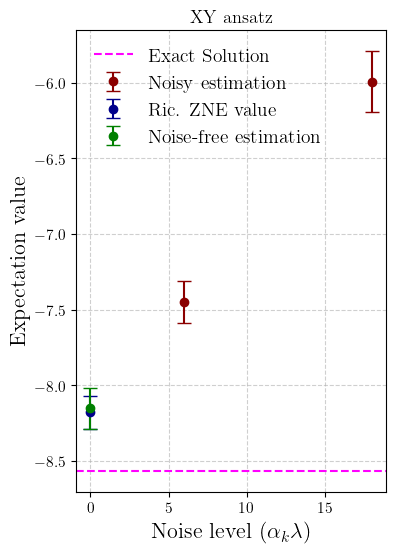

Figure saved as (in 'plots' folder): xy_ansatz_noise_free_tevo.eps


In [11]:
# Plot size
plt.figure(figsize=(4, 6))

# Noisy estimation
plt.errorbar(
    x=noise_levels,
    y=noisy_vqe_vals["xy"]["mean"],
    yerr=noisy_vqe_vals["xy"]["std"], 
    fmt="o", 
    ecolor=plot_colors[0],
    capsize=5, 
    label="Noisy estimation", 
    color=plot_colors[0]
)
# Extrapolated
plt.errorbar(
    x=extrapolated_noise, 
    y=zne_vals["xy"]["mean"], 
    yerr=zne_vals["xy"]["std"], 
    fmt="o", 
    ecolor=plot_colors[2],
    capsize=5, 
    label="Ric. ZNE value", 
    color=plot_colors[2]
)
# Noise-free 
plt.errorbar(
    x=0, 
    y=noise_off_vqe_vals["xy"]["mean"], 
    yerr=noise_off_vqe_vals["xy"]["std"], 
    fmt="o", 
    ecolor=plot_colors[6],
    capsize=5, 
    label="Noise-free estimation", 
    color=plot_colors[6]
)
# Exact solution
plt.axhline(y=exact_sol, color=plot_colors[5], linestyle="--", label=f"Exact Solution")

# Labels and title
plt.xlabel(r"Noise level ($\alpha_k\lambda$)", fontsize=16)
plt.ylabel("Expectation value", fontsize=16)
plt.title(plot_titles["xy"])
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend(loc="upper left", fontsize=14, frameon=False)
# Save as eps
plt.savefig(f"plots/{plot_export_names['xy']}", format="eps")
plt.show()
print("Figure saved as (in 'plots' folder):", plot_export_names["xy"])

### (B) Heisenberg ansatz plot

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


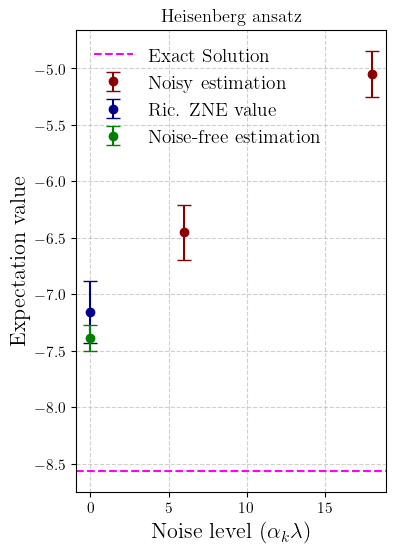

Figure saved as (in 'plots' folder): {'heisenberg_ansatz_further_ric3'}


In [12]:
# Plot size
plt.figure(figsize=(4, 6))

# Noisy estimation
plt.errorbar(
    x=noise_levels,
    y=noisy_vqe_vals["heisenberg"]["mean"],
    yerr=noisy_vqe_vals["heisenberg"]["std"], 
    fmt="o", 
    ecolor=plot_colors[0],
    capsize=5, 
    label="Noisy estimation", 
    color=plot_colors[0]
)
# Extrapolated
plt.errorbar(
    x=extrapolated_noise, 
    y=zne_vals["heisenberg"]["mean"], 
    yerr=zne_vals["heisenberg"]["std"], 
    fmt="o", 
    ecolor=plot_colors[2],
    capsize=5, 
    label="Ric. ZNE value", 
    color=plot_colors[2]
)
# Noise-free 
plt.errorbar(
    x=0, 
    y=noise_off_vqe_vals["heisenberg"]["mean"], 
    yerr=noise_off_vqe_vals["heisenberg"]["std"], 
    fmt="o", 
    ecolor=plot_colors[6],
    capsize=5, 
    label="Noise-free estimation", 
    color=plot_colors[6]
)
# Exact solution
plt.axhline(y=exact_sol, color=plot_colors[5], linestyle="--", label=f"Exact Solution")

# Labels and title
plt.xlabel(r"Noise level ($\alpha_k\lambda$)", fontsize=16)
plt.ylabel("Expectation value", fontsize=16)
plt.title(plot_titles["heisenberg"])
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend(loc="upper left", fontsize=14, frameon=False)
# Save as eps
plt.savefig(f"plots/{plot_export_names['heisenberg_further1']}", format="eps")
plt.show()
print("Figure saved as (in 'plots' folder):", {plot_export_names['heisenberg_further1']})

## (5) Compiled plots

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


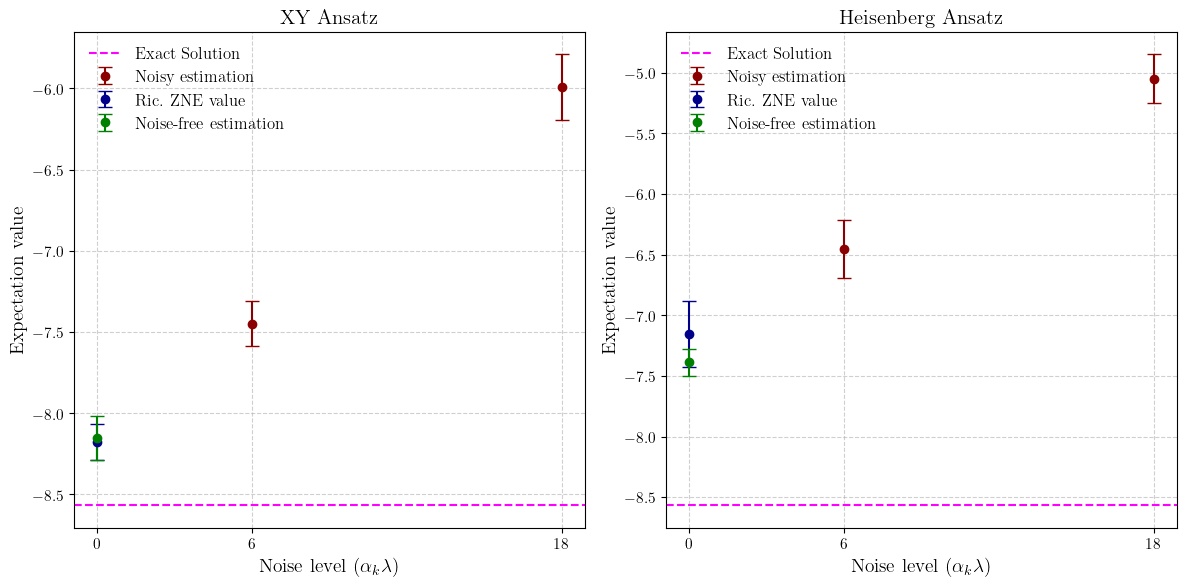

Figure saved as (in 'plots' folder): compiled.eps


In [13]:
# Create subplots: 1 row, 2 columns
fig, axes = plt.subplots(1, 2, figsize=(12, 6))  # Adjust figsize for wider plots

# XY plot (first subplot)
axes[0].errorbar(
    x=noise_levels,
    y=noisy_vqe_vals["xy"]["mean"],
    yerr=noisy_vqe_vals["xy"]["std"],
    fmt="o",
    ecolor=plot_colors[0],
    capsize=5,
    label="Noisy estimation",
    color=plot_colors[0],
)
axes[0].errorbar(
    x=extrapolated_noise,
    y=zne_vals["xy"]["mean"],
    yerr=zne_vals["xy"]["std"],
    fmt="o",
    ecolor=plot_colors[2],
    capsize=5,
    label="Ric. ZNE value",
    color=plot_colors[2],
)
axes[0].errorbar(
    x=extrapolated_noise,
    y=noise_off_vqe_vals["xy"]["mean"],
    yerr=noise_off_vqe_vals["xy"]["std"],
    fmt="o",
    ecolor=plot_colors[6],
    capsize=5,
    label="Noise-free estimation",
    color=plot_colors[6],
)
axes[0].axhline(
    y=exact_sol,
    color=plot_colors[5],
    linestyle="--",
    label="Exact Solution",
)
axes[0].set_xlabel(r"Noise level ($\alpha_k\lambda$)", fontsize=14)
axes[0].set_ylabel("Expectation value", fontsize=14)
axes[0].set_title("XY Ansatz", fontsize=15)
axes[0].grid(True, linestyle="--", alpha=0.6)
axes[0].legend(loc="upper left", fontsize=12, frameon=False)
axes[0].set_xticks([extrapolated_noise] + noise_levels)

# Heisenberg plot (second subplot)
axes[1].errorbar(
    x=noise_levels,
    y=noisy_vqe_vals["heisenberg"]["mean"],
    yerr=noisy_vqe_vals["heisenberg"]["std"],
    fmt="o",
    ecolor=plot_colors[0],
    capsize=5,
    label="Noisy estimation",
    color=plot_colors[0],
)
axes[1].errorbar(
    x=extrapolated_noise,
    y=zne_vals["heisenberg"]["mean"],
    yerr=zne_vals["heisenberg"]["std"],
    fmt="o",
    ecolor=plot_colors[2],
    capsize=5,
    label="Ric. ZNE value",
    color=plot_colors[2],
)
axes[1].errorbar(
    x=extrapolated_noise,
    y=noise_off_vqe_vals["heisenberg"]["mean"],
    yerr=noise_off_vqe_vals["heisenberg"]["std"],
    fmt="o",
    ecolor=plot_colors[6],
    capsize=5,
    label="Noise-free estimation",
    color=plot_colors[6],
)
axes[1].axhline(
    y=exact_sol,
    color=plot_colors[5],
    linestyle="--",
    label="Exact Solution",
)
axes[1].set_xlabel(r"Noise level ($\alpha_k\lambda$)", fontsize=14)
axes[1].set_ylabel("Expectation value", fontsize=14)
axes[1].set_title("Heisenberg Ansatz", fontsize=15)
axes[1].grid(True, linestyle="--", alpha=0.6)
axes[1].legend(loc="upper left", fontsize=12, frameon=False)
axes[1].set_xticks([extrapolated_noise] + noise_levels)

# Adjust layout and display
plt.tight_layout()

# Save figure (optional)
plt.savefig(f"plots/{plot_export_names['compiled']}", format="eps")
plt.show()

print("Figure saved as (in 'plots' folder):", plot_export_names['compiled'])


---

## (5) Further studies on Heisenberg ansatz

### (A) Load JSON data

In [14]:
# Define the path to the "heisenberg_further" folder
heisenberg_further_path = os.path.join(base_path, "heisenberg_further")

# Initialize a dictionary to store the data from the JSON files
heisenberg_further_data: dict = {"ric3": [], "ricmul": []}

# Check if the folder exists
if os.path.exists(heisenberg_further_path):
    # List all JSON files in the folder
    json_files = [f for f in os.listdir(heisenberg_further_path) if f.endswith(".json")]
    
    # Load each JSON file and categorize based on the filename
    for json_file in json_files:
        file_path = os.path.join(heisenberg_further_path, json_file)
        with open(file_path, "r") as f:
            data = json.load(f)
            if "ric3" in json_file.lower():
                heisenberg_further_data["ric3"].append(data)
            elif "ricmul" in json_file.lower():
                heisenberg_further_data["ricmul"].append(data)
else:
    print(f"Folder {heisenberg_further_path} not found.")

# Print the number of files loaded for each category
print(f"3-point Richardson ZNE: Loaded {len(heisenberg_further_data['ric3'])} JSON files with 'ric3' in their name.")
print(f"Multivariate Richardson ZNE: Loaded {len(heisenberg_further_data['ricmul'])} JSON files with 'ricmul' in their name.")

3-point Richardson ZNE: Loaded 10 JSON files with 'ric3' in their name.
Multivariate Richardson ZNE: Loaded 10 JSON files with 'ricmul' in their name.


Tabular view

In [15]:
# Normalize the JSON data into a flat table
# ricmul_data = heisenberg_further_data["ricmul"]

# if ricmul_data:
#     df = pd.json_normalize(ricmul_data)

#     # Print the table
#     print(tabulate(df, headers="keys", tablefmt="grid", showindex=False))
# else:
#     print("No data found for 'ricmul'.")


In [16]:
print(np.mean([-7.08552, -7.20252, -7.51398, -7.29908, -7.17222, -6.64612, -7.4484, -6.8865,  -6.85523, -7.44941]))
print(np.std([-7.08552, -7.20252, -7.51398, -7.29908, -7.17222, -6.64612, -7.4484, -6.8865,  -6.85523, -7.44941]))

-7.1558980000000005
0.2739842581901378


### (B) Noisy VQE values



In [17]:
# Extract sampled data arrays for both XY and Heisenberg ansätze
heisenberg_ric3 = [entry["output"]["zne_values"]["sampled data"] for entry in heisenberg_further_data["ric3"]]
heisenberg_mul = [entry["output"]["zne_values"]["sampled data"] for entry in heisenberg_further_data["ricmul"]]

# Compute noisy VQE statistics
noisy_vqe_vals_further: dict = {
    "ric3": {
        "mean": [
            np.mean([sample[0][4] for sample in heisenberg_ric3]),  # Unboosted (noise level 6)
            np.mean([sample[1][4] for sample in heisenberg_ric3]),  # Boosted (noise level 18)
            np.mean([sample[2][4] for sample in heisenberg_ric3]), # Bossted (noise level 26)
        ],
        "std": [
            np.std([sample[0][4] for sample in heisenberg_ric3]),   # Unboosted
            np.std([sample[1][4] for sample in heisenberg_ric3]),   # Boosted
            np.std([sample[2][4] for sample in heisenberg_ric3])    # Boosted
        ],
    },
    "ricmul": {
        "mean": [
            np.mean([sample[0][2] for sample in heisenberg_mul]),  # Unboosted
            np.mean([sample[1][2] for sample in heisenberg_mul]),  # Boosted
            np.mean([sample[2][2] for sample in heisenberg_mul])    # Boosted
        ],
        "std": [
            np.std([sample[0][2] for sample in heisenberg_mul]),   # Unboosted
            np.std([sample[1][2] for sample in heisenberg_mul]),   # Boosted
            np.std([sample[2][2] for sample in heisenberg_mul]),   # Boosted
        ],
    },
}
# Lets print the values as well
# Labels
headers = ["Description", "Noise Level", "Mean", "Std Dev"]

# Data rows
rows = [
    ["Heisenberg (ric3)", "Unboosted (noise 4)", noisy_vqe_vals_further["ric3"]["mean"][0], noisy_vqe_vals_further["ric3"]["std"][0]],
    ["Heisenberg (ric3)", "Boosted (noise 18)", noisy_vqe_vals_further["ric3"]["mean"][1], noisy_vqe_vals_further["ric3"]["std"][1]],
    ["Heisenberg (ric3)", "Boosted (noise 26)", noisy_vqe_vals_further["ric3"]["mean"][2], noisy_vqe_vals_further["ric3"]["std"][2]],
    ["Heisenberg (ricmul)", "Unboosted (noise [4, 2])", noisy_vqe_vals_further["ricmul"]["mean"][0], noisy_vqe_vals_further["ricmul"]["std"][0]],
    ["Heisenberg (ricmul)", "Boosted (noise [12, 6])", noisy_vqe_vals_further["ricmul"]["mean"][1], noisy_vqe_vals_further["ricmul"]["std"][1]],
    ["Heisenberg (ricmul)", "Boosted (noise [20, 6])", noisy_vqe_vals_further["ricmul"]["mean"][2], noisy_vqe_vals_further["ricmul"]["std"][2]],
]

# Print table
print(tabulate(rows, headers=headers, floatfmt=".6f", tablefmt="grid"))

+---------------------+--------------------------+-----------+-----------+
| Description         | Noise Level              |      Mean |   Std Dev |
+=====================+==========================+===========+===========+
| Heisenberg (ric3)   | Unboosted (noise 4)      | -6.453399 |  0.240208 |
+---------------------+--------------------------+-----------+-----------+
| Heisenberg (ric3)   | Boosted (noise 18)       | -5.048399 |  0.201367 |
+---------------------+--------------------------+-----------+-----------+
| Heisenberg (ric3)   | Boosted (noise 26)       | -4.145995 |  0.197116 |
+---------------------+--------------------------+-----------+-----------+
| Heisenberg (ricmul) | Unboosted (noise [4, 2]) | -6.453399 |  0.240208 |
+---------------------+--------------------------+-----------+-----------+
| Heisenberg (ricmul) | Boosted (noise [12, 6])  | -5.048399 |  0.201367 |
+---------------------+--------------------------+-----------+-----------+
| Heisenberg (ricmul) | B

### (C) 3-point ZNE estimations

In [18]:
heisenberg_further_zne_vals : dict={
    "ric3": {
        "mean": np.mean([entry["output"]["zne_values"]["extrapolated_value"] for entry in heisenberg_further_data["ric3"]]),
        "std": np.std([entry["output"]["zne_values"]["extrapolated_value"] for entry in heisenberg_further_data["ric3"]])
    },
    "ricmul": {
        "mean": np.mean([entry["output"]["zne_values"]["extrapolated_value"] for entry in heisenberg_further_data["ricmul"]]),
        "std": np.std([entry["output"]["zne_values"]["extrapolated_value"] for entry in heisenberg_further_data["ricmul"]])
    }
}

# Prepare data for tabulate
headers = ["Description", "Mean", "Std Dev"]
rows = [
    ["Heisenberg (ric2)", zne_vals["heisenberg"]["mean"], zne_vals["heisenberg"]["std"]],
    ["Heisenberg (ric3)", heisenberg_further_zne_vals["ric3"]["mean"], heisenberg_further_zne_vals["ric3"]["std"]],
    ["Heisenberg (ricmul)", heisenberg_further_zne_vals["ricmul"]["mean"], heisenberg_further_zne_vals["ricmul"]["std"]],
]

# Print the table
print("Comparison between 2 point ZNE, 3-point ZNE and multivariate ZNE")
print(tabulate(rows, headers=headers, floatfmt=".15f", tablefmt="grid"))

Comparison between 2 point ZNE, 3-point ZNE and multivariate ZNE
+---------------------+--------------------+-------------------+
| Description         |               Mean |           Std Dev |
+=====================+====================+===================+
| Heisenberg (ric2)   | -7.155899022550829 | 0.273985176027449 |
+---------------------+--------------------+-------------------+
| Heisenberg (ric3)   | -7.179026299919016 | 0.278562360015543 |
+---------------------+--------------------+-------------------+
| Heisenberg (ricmul) | -7.155899022550829 | 0.273985176027449 |
+---------------------+--------------------+-------------------+


### (D) Plot

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


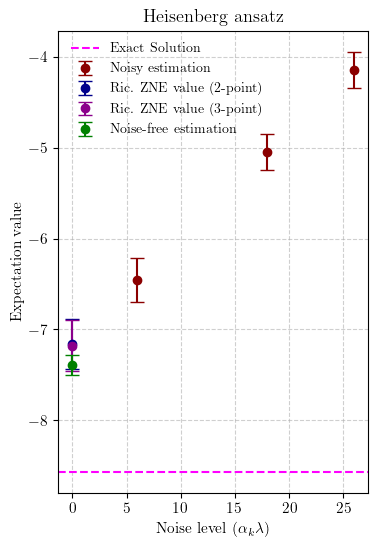

Figure saved as (in 'plots' folder): {'heisenberg_ansatz_noise_free_tevo.eps'}


In [19]:
# Plot size
plt.figure(figsize=(4, 6))
noise_levels = [6, 18, 26]
# Noisy estimation
plt.errorbar(
    x=noise_levels,
    y=noisy_vqe_vals_further["ric3"]["mean"],
    yerr=noisy_vqe_vals_further["ric3"]["std"], 
    fmt="o", 
    ecolor=plot_colors[0],
    capsize=5, 
    label="Noisy estimation", 
    color=plot_colors[0]
)
# 2-point Richardson ZNE
plt.errorbar(
    x=extrapolated_noise, 
    y=zne_vals["heisenberg"]["mean"], 
    yerr=zne_vals["heisenberg"]["std"], 
    fmt="o", 
    ecolor=plot_colors[2],
    capsize=5, 
    label="Ric. ZNE value (2-point)", 
    color=plot_colors[2]
)
# 3-pont Richardson ZNE
plt.errorbar(
    x=extrapolated_noise, 
    y=heisenberg_further_zne_vals["ric3"]["mean"], 
    yerr=heisenberg_further_zne_vals["ric3"]["std"], 
    fmt="o", 
    ecolor=plot_colors[3],
    capsize=5, 
    label="Ric. ZNE value (3-point)", 
    color=plot_colors[3]
)
# Noise-free 
plt.errorbar(
    x=0, 
    y=noise_off_vqe_vals["heisenberg"]["mean"], 
    yerr=noise_off_vqe_vals["heisenberg"]["std"], 
    fmt="o", 
    ecolor=plot_colors[6],
    capsize=5, 
    label="Noise-free estimation", 
    color=plot_colors[6]
)
# Exact solution
plt.axhline(y=exact_sol, color=plot_colors[5], linestyle="--", label=f"Exact Solution")

# Labels and title
plt.xlabel(r"Noise level ($\alpha_k\lambda$)")
plt.ylabel("Expectation value")
plt.title(plot_titles["heisenberg"])
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend(loc="upper left", frameon=False)
# Save as eps
plt.savefig(f"plots/{plot_export_names['heisenberg']}", format="eps")
plt.show()
print("Figure saved as (in 'plots' folder):", {plot_export_names['heisenberg']})

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


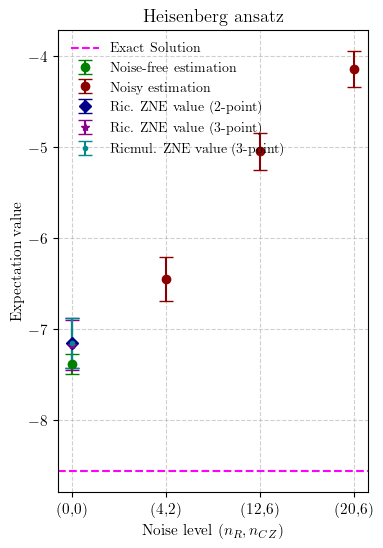

Figure saved as (in 'plots' folder): {'heisenberg_ansatz_noise_free_tevo.eps'}


In [20]:
# Plot size
plt.figure(figsize=(4, 6))

# Map noise levels to numeric x-axis positions
x_labels = ["(0,0)", "(4,2)", "(12,6)", "(20,6)"]
x_positions = list(range(len(x_labels)))  # [0, 1, 2, 3]

# Plot Noise-free estimation (position 0)
plt.errorbar(
    x=x_positions[0], 
    y=noise_off_vqe_vals["heisenberg"]["mean"], 
    yerr=noise_off_vqe_vals["heisenberg"]["std"], 
    fmt="o", 
    ecolor=plot_colors[6],
    capsize=5, 
    label="Noise-free estimation", 
    color=plot_colors[6]
)

# Noisy estimations (positions 1, 2, 3)
plt.errorbar(
    x=x_positions[1:], 
    y=noisy_vqe_vals_further["ric3"]["mean"], 
    yerr=noisy_vqe_vals_further["ric3"]["std"], 
    fmt="o", 
    ecolor=plot_colors[0],
    capsize=5, 
    label="Noisy estimation", 
    color=plot_colors[0]
)

# ZNE (position 0)

# 2-point Richardson ZNE (corresponding noise levels are 6 and 18)
plt.errorbar(
    x=x_positions[0], 
    y=zne_vals["heisenberg"]["mean"], 
    yerr=zne_vals["heisenberg"]["std"], 
    fmt="D", 
    ecolor=plot_colors[2],
    capsize=5, 
    label="Ric. ZNE value (2-point)", 
    color=plot_colors[2]
)
# 3-point Richardson ZNE (corresponding noise levels are 6, 18, 26)
plt.errorbar(
    x=x_positions[0], 
    y=heisenberg_further_zne_vals["ric3"]["mean"], 
    yerr=heisenberg_further_zne_vals["ric3"]["std"], 
    fmt="*", 
    ecolor=plot_colors[3],
    capsize=5, 
    label="Ric. ZNE value (3-point)", 
    color=plot_colors[3]
)

# Multivatiate Richardson ZNE (2 independent variables, degree 1)
plt.errorbar(
    x=x_positions[0], 
    y=heisenberg_further_zne_vals["ricmul"]["mean"], 
    yerr=heisenberg_further_zne_vals["ricmul"]["std"], 
    fmt=".", 
    ecolor=plot_colors[4],
    capsize=5, 
    label="Ricmul. ZNE value (3-point)", 
    color=plot_colors[4]
)

# Exact solution
plt.axhline(y=exact_sol, color=plot_colors[5], linestyle="--", label="Exact Solution")

# X-axis labels and ticks
plt.xticks(ticks=x_positions, labels=x_labels)

# Labels and title
plt.xlabel(r"Noise level ($n_R, n_{CZ}$)")
plt.ylabel("Expectation value")
plt.title(plot_titles["heisenberg"])
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend(loc="upper left", frameon=False)

# Save as EPS
plt.savefig(f"plots/{plot_export_names['heisenberg']}", format="eps")
plt.show()

print("Figure saved as (in 'plots' folder):", {plot_export_names['heisenberg']})

---

Now for the 3-point ZNE, lets choose a different set of identity factors. In other words, we will be using different noisy estimations for extrapolation.

In [21]:
# Define the path to the "heisenberg_further2" folder
heisenberg_further2_path = os.path.join(base_path, "heisenberg_further2")

# Initialize a dictionary to store the data from the JSON files
heisenberg_further2_data: dict = {"zne": []}

# Check if the folder exists
if os.path.exists(heisenberg_further2_path):
    # List all JSON files in the folder
    json_files = [f for f in os.listdir(heisenberg_further2_path) if f.endswith(".json")]
    
    # Load each JSON file and categorize based on the filename
    for json_file in json_files:
        file_path = os.path.join(heisenberg_further2_path, json_file)
        with open(file_path, "r") as f:
            data = json.load(f)
            if "zne" in json_file.lower():
                heisenberg_further2_data["zne"].append(data)

else:
    print(f"Folder {heisenberg_further2_path} not found.")

# Print the number of files loaded for each category
print(f"3-point Richardson ZNE: Loaded {len(heisenberg_further2_data['zne'])} JSON files with 'zne' in their name.")

3-point Richardson ZNE: Loaded 10 JSON files with 'zne' in their name.


In [22]:
heisenberg_further2_zne_mean: float= np.mean([entry["output"]["zne_values"]["extrapolated_value"] for entry in heisenberg_further2_data["zne"]])
heisenberg_further2_zne_std: float= np.std([entry["output"]["zne_values"]["extrapolated_value"] for entry in heisenberg_further2_data["zne"]])
noise_further_2_noise = [6, 18, 30]
noisy_vqe_vals_further2_mean: float= np.mean([entry["output"]["zne_values"]["sampled data"][2][4] for entry in heisenberg_further2_data["zne"]])
noisy_vqe_vals_further2_std: float= np.std([entry["output"]["zne_values"]["sampled data"][2][4] for entry in heisenberg_further2_data["zne"]])

In [23]:
# Print tabulated data for heisenberg further studies 2
print(tabulate(heisenberg_further2_data["zne"], headers="keys", tablefmt="grid"))

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


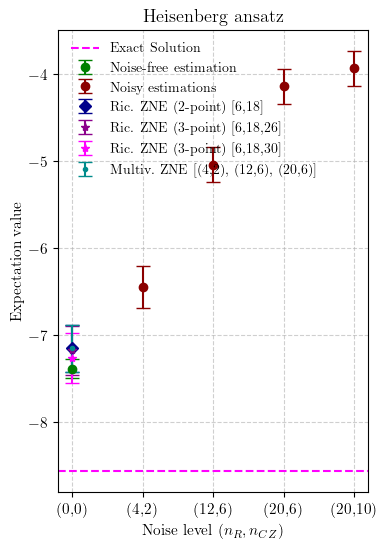

Figure saved as (in 'plots' folder): heisenberg_ansatz_noise_free_tevo.eps


In [24]:
import matplotlib.pyplot as plt

# Plot setup
plt.figure(figsize=(4, 6))
x_labels = ["(0,0)", "(4,2)", "(12,6)", "(20,6)", "(20,10)"]
x_positions = list(range(len(x_labels)))

# === Noise-free estimation at (0,0) ===
plt.errorbar(
    x=x_positions[0],
    y=noise_off_vqe_vals["heisenberg"]["mean"],
    yerr=noise_off_vqe_vals["heisenberg"]["std"],
    fmt="o",
    color=plot_colors[6],
    ecolor=plot_colors[6],
    capsize=5,
    label="Noise-free estimation"
)

# === Noisy estimations ===
# From (4,2), (12,6), (20,6)
plt.errorbar(
    x=[1, 2, 3],
    y=noisy_vqe_vals_further["ric3"]["mean"],
    yerr=noisy_vqe_vals_further["ric3"]["std"],
    fmt="o",
    color=plot_colors[0],
    ecolor=plot_colors[0],
    capsize=5,
    label="Noisy estimations"
)

# From (20,10)
plt.errorbar(
    x=[4],
    y=noisy_vqe_vals_further2_mean,
    yerr=noisy_vqe_vals_further2_std,
    fmt="o",
    color=plot_colors[0],
    ecolor=plot_colors[0],
    capsize=5
)

# === Extrapolated ZNE values (always plotted at (0,0)) ===
# 2-point Richardson ZNE (6,18)
plt.errorbar(
    x=x_positions[0],
    y=zne_vals["heisenberg"]["mean"],
    yerr=zne_vals["heisenberg"]["std"],
    fmt="D",
    color=plot_colors[2],
    ecolor=plot_colors[2],
    capsize=5,
    label="Ric. ZNE (2-point) [6,18]"
)

# 3-point Richardson ZNE (6,18,26)
plt.errorbar(
    x=x_positions[0],
    y=heisenberg_further_zne_vals["ric3"]["mean"],
    yerr=heisenberg_further_zne_vals["ric3"]["std"],
    fmt="*",
    color=plot_colors[3],
    ecolor=plot_colors[3],
    capsize=5,
    label="Ric. ZNE (3-point) [6,18,26]"
)

# 3-point Richardson ZNE (6,18,30) from (20,10)
plt.errorbar(
    x=x_positions[0],
    y=heisenberg_further2_zne_mean,
    yerr=heisenberg_further2_zne_std,
    fmt="*",
    color=plot_colors[5],
    ecolor=plot_colors[5],
    capsize=5,
    label="Ric. ZNE (3-point) [6,18,30]"
)

# Multivariate Richardson ZNE
plt.errorbar(
    x=x_positions[0],
    y=heisenberg_further_zne_vals["ricmul"]["mean"],
    yerr=heisenberg_further_zne_vals["ricmul"]["std"],
    fmt=".",
    color=plot_colors[4],
    ecolor=plot_colors[4],
    capsize=5,
    label="Multiv. ZNE [(4,2), (12,6), (20,6)]"
)



# === Exact solution ===
plt.axhline(y=exact_sol, color=plot_colors[5], linestyle="--", label="Exact Solution")

# === Formatting ===
plt.xticks(ticks=x_positions, labels=x_labels)
plt.xlabel(r"Noise level ($n_R, n_{CZ}$)")
plt.ylabel("Expectation value")
plt.title(plot_titles["heisenberg"])
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend(loc="upper left", frameon=False)

# Save and show plot
plt.savefig(f"plots/{plot_export_names['heisenberg']}", format="eps")
plt.show()
print("Figure saved as (in 'plots' folder):", plot_export_names["heisenberg"])


Summary of Heisenberg ansatz ZNE

In [25]:
summary_heisenberg: dict= {
    "2-point-zne":{
        "noisy_est":{
            "noise":[6, 18],
            "est": [noisy_vqe_vals["heisenberg"]["mean"][0], noisy_vqe_vals["heisenberg"]["mean"][1]],
            "std": [noisy_vqe_vals["heisenberg"]["std"][0], noisy_vqe_vals["heisenberg"]["std"][1]]
        },
        "zne":{
            "est":zne_vals["heisenberg"]["mean"],
            "std":zne_vals["heisenberg"]["std"]
        }
    },
    "3-point-zne":{
        "noisy_est":{
            "noise": [6, 18, 26],
            "est":  noisy_vqe_vals_further["ric3"]["mean"],
            "std": noisy_vqe_vals_further["ric3"]["std"]
        },
        "zne":{
            "est": heisenberg_further_zne_vals["ric3"]["mean"],
            "std": heisenberg_further_zne_vals["ric3"]["std"]
        }
    },
    "3-point-zne-2":{
        "noisy_est":{
            "noise": [6, 18, 30],
            "est": [noisy_vqe_vals["heisenberg"]["mean"][0], noisy_vqe_vals["heisenberg"]["mean"][1], noisy_vqe_vals_further2_mean],
            "std": [noisy_vqe_vals["heisenberg"]["std"][0], noisy_vqe_vals["heisenberg"]["std"][1], noisy_vqe_vals_further2_std]
        },
        "zne":{
            "est": heisenberg_further2_zne_mean,
            "std": heisenberg_further2_zne_std
        }
    },
    "zne-mulvar":{
        "noisy_est":{
            "noise": [(4, 2), (12, 6), (20, 6)],
            "est": noisy_vqe_vals_further["ricmul"]["mean"],
            "std": noisy_vqe_vals_further["ricmul"]["std"]
    },
        "zne":{
            "est": heisenberg_further_zne_vals["ricmul"]["mean"],
            "std": heisenberg_further_zne_vals["ricmul"]["std"]
        }
    }
}

Tabulating the summary

In [26]:
def format_val_std(est, std):
    """Format estimate and std as 'value ± std' rounded to 4 decimals."""
    return [f"{e:.4f} ± {s:.4f}" for e, s in zip(est, std)]

def tabulate_summary_equal_width(summary):
    col_widths = {
        "method": 20,
        "noise": 25,
        "noisy_est": 45,
        "zne_est": 25
    }

    header = (
        f"{'ZNE Method':<{col_widths['method']}} | "
        f"{'Noisy Noise Levels':<{col_widths['noise']}} | "
        f"{'Noisy Estimates (± Std)':<{col_widths['noisy_est']}} | "
        f"{'ZNE Estimate (± Std)':<{col_widths['zne_est']}}"
    )
    print(header)
    print("-" * (sum(col_widths.values()) + 9))  # 9 for separators and spaces

    for method, data in summary.items():
        noisy_noise = data["noisy_est"]["noise"]
        noisy_est = data["noisy_est"]["est"]
        noisy_std = data["noisy_est"]["std"]
        zne_est = data["zne"]["est"]
        zne_std = data["zne"]["std"]

        # Format noisy noise levels nicely
        if isinstance(noisy_noise, (list, tuple)):
            noisy_noise_str = ", ".join(
                str(n) if not isinstance(n, tuple) else f"({n[0]}, {n[1]})" 
                for n in noisy_noise
            )
        else:
            noisy_noise_str = str(noisy_noise)

        noisy_str = ", ".join(format_val_std(noisy_est, noisy_std))
        if isinstance(zne_est, (list, tuple)):
            zne_str = ", ".join(format_val_std(zne_est, zne_std))
        else:
            zne_str = f"{zne_est:.4f} ± {zne_std:.4f}"

        print(
            f"{method:<{col_widths['method']}} | "
            f"{noisy_noise_str:<{col_widths['noise']}} | "
            f"{noisy_str:<{col_widths['noisy_est']}} | "
            f"{zne_str:<{col_widths['zne_est']}}"
        )

# Call the function with your summary dictionary
tabulate_summary_equal_width(summary_heisenberg)


ZNE Method           | Noisy Noise Levels        | Noisy Estimates (± Std)                       | ZNE Estimate (± Std)     
----------------------------------------------------------------------------------------------------------------------------
2-point-zne          | 6, 18                     | -6.4534 ± 0.2402, -5.0484 ± 0.2014            | -7.1559 ± 0.2740         
3-point-zne          | 6, 18, 26                 | -6.4534 ± 0.2402, -5.0484 ± 0.2014, -4.1460 ± 0.1971 | -7.1790 ± 0.2786         
3-point-zne-2        | 6, 18, 30                 | -6.4534 ± 0.2402, -5.0484 ± 0.2014, -3.9399 ± 0.1967 | -7.2671 ± 0.2830         
zne-mulvar           | (4, 2), (12, 6), (20, 6)  | -6.4534 ± 0.2402, -5.0484 ± 0.2014, -4.1460 ± 0.1971 | -7.1559 ± 0.2740         


---

# EXTRA

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


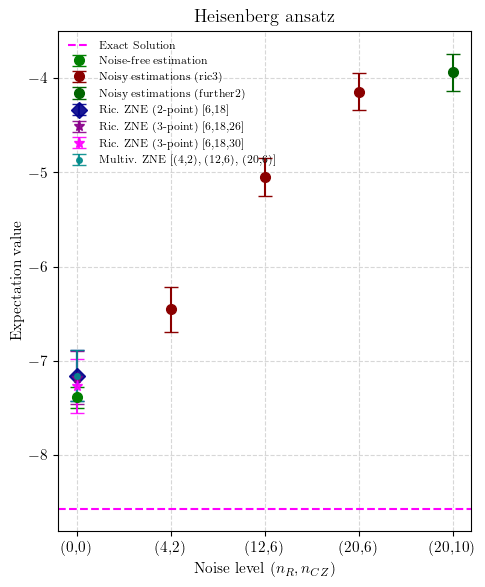

Figure saved as (in 'plots' folder): heisenberg_ansatz_noise_free_tevo.eps


In [27]:

# Plot setup
plt.figure(figsize=(5, 6))  # Slightly wider for clarity
x_labels = ["(0,0)", "(4,2)", "(12,6)", "(20,6)", "(20,10)"]
x_positions = list(range(len(x_labels)))

# === Noise-free estimation at (0,0) ===
plt.errorbar(
    x=x_positions[0],
    y=noise_off_vqe_vals["heisenberg"]["mean"],
    yerr=noise_off_vqe_vals["heisenberg"]["std"],
    fmt="o",
    color=plot_colors[6],
    ecolor=plot_colors[6],
    capsize=5,
    label="Noise-free estimation",
    markersize=7,
)

# === Noisy estimations ===
# From (4,2), (12,6), (20,6)
plt.errorbar(
    x=[1, 2, 3],
    y=noisy_vqe_vals_further["ric3"]["mean"],
    yerr=noisy_vqe_vals_further["ric3"]["std"],
    fmt="o",
    color=plot_colors[0],
    ecolor=plot_colors[0],
    capsize=5,
    label="Noisy estimations (ric3)",
    markersize=7,
)

# From (20,10)
plt.errorbar(
    x=[4],
    y=noisy_vqe_vals_further2_mean,
    yerr=noisy_vqe_vals_further2_std,
    fmt="o",
    color=plot_colors[1],  # Use different color for this to separate
    ecolor=plot_colors[1],
    capsize=5,
    label="Noisy estimations (further2)",
    markersize=7,
)

# === Extrapolated ZNE values at (0,0) ===
zne_items = [
    ("Ric. ZNE (2-point) [6,18]", zne_vals["heisenberg"], plot_colors[2], "D"),
    ("Ric. ZNE (3-point) [6,18,26]", heisenberg_further_zne_vals["ric3"], plot_colors[3], "*"),
    ("Ric. ZNE (3-point) [6,18,30]", {"mean": heisenberg_further2_zne_mean, "std": heisenberg_further2_zne_std}, plot_colors[5], "*"),
    ("Multiv. ZNE [(4,2), (12,6), (20,6)]", heisenberg_further_zne_vals["ricmul"], plot_colors[4], "."),
]

for label, data, color, marker in zne_items:
    mean = data["mean"] if isinstance(data, dict) else data.mean
    std = data["std"] if isinstance(data, dict) else data.std
    plt.errorbar(
        x=x_positions[0],
        y=mean,
        yerr=std,
        fmt=marker,
        color=color,
        ecolor=color,
        capsize=5,
        label=label,
        markersize=8,
        alpha=0.9,
    )

# === Exact solution ===
plt.axhline(y=exact_sol, color=plot_colors[5], linestyle="--", label="Exact Solution")

# === Formatting ===
plt.xticks(ticks=x_positions, labels=x_labels)
plt.xlabel(r"Noise level ($n_R, n_{CZ}$)")
plt.ylabel("Expectation value")
plt.title(plot_titles["heisenberg"])
plt.grid(True, linestyle="--", alpha=0.5)

# Make legend smaller and split noisy estimations by color & label
plt.legend(loc="upper left", frameon=False, fontsize=8)

plt.tight_layout()
plt.savefig(f"plots/{plot_export_names['heisenberg']}", format="eps")
plt.show()

print("Figure saved as (in 'plots' folder):", plot_export_names["heisenberg"])
